# Hate Speech Detection using Bidrectional GRU on a balanced dataset

Now we use Bi-directional GRU with Max Pooling and Early Stopping F1-Score callbacks 

## Import Necessary Libraries

In [1]:
!pip install nltk

In [2]:
!pip install scikit-learn

In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Input, Embedding, Bidirectional, LSTM, GRU, GlobalMaxPooling1D, Dropout, Dense
from tensorflow.keras.models import Model
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from nltk.corpus import stopwords
import re
import matplotlib.pyplot as plt
import nltk
from nltk.corpus import stopwords

## Load Dataset

Source : [Hate Speech Detection Curated Dataset](https://www.kaggle.com/datasets/waalbannyantudre/hate-speech-detection-curated-dataset) <br> The dataset was very good in comparison to the previous ones used. The large number of rows made sure that overfitting was avoided without having to do data augmentation. To top it off, a balanced dataset was available to reduce any bias.

In [2]:
file = "/kaggle/input/hate-speech-detection-curated-dataset/HateSpeechDatasetBalanced.csv"
df = pd.read_csv(file)
df.head()

,Content,Label
0,denial of normal the con be asked to comment o...,1
1,just by being able to tweet this insufferable ...,1
2,that is retarded you too cute to be single tha...,1
3,thought of a real badass mongol style declarat...,1
4,afro american basho,1


In [3]:
df.tail()

,Content,Label
726114,i mute this telecasting and played kanye west ...,1
726115,but hell yeah he s not a bachelor but looooooo...,1
726116,great video musician but s not my musician lol...,1
726117,not great pop video yeah he s not a pedophile ...,1
726118,great video yeah he s non a paedophile lolllll...,1


In [4]:
df.shape

(726119, 2)

In [5]:
df['Label'].unique()

array([1, 0])

## Preprocessing Text

In [6]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [7]:
stp = set(stopwords.words("english"))

# Function to preprocess text
def preprocess_text(text):
    text = re.sub("[^a-zA-Z]", " ", text)
    text = text.lower()
    text = text.split()
    words = [word for word in text if word not in stp]
    return " ".join(words)
df['ProcessedContent'] = df['Content'].apply(preprocess_text)

### Tokenization

In [8]:
from keras._tf_keras.keras.preprocessing.text import Tokenizer
tokenizer = Tokenizer()
tokenizer.fit_on_texts(df['ProcessedContent'])
sequences = tokenizer.texts_to_sequences(df['ProcessedContent'])

In [9]:
max_len=max([max(0,len(seq)) for seq in sequences])
max_len

294

### Padding Sequences <br>
> Ensures all sequences are of same length

In [10]:
from keras._tf_keras.keras.preprocessing.sequence import pad_sequences
x = pad_sequences(sequences, maxlen=max_len)
y = df['Label'].values

In [11]:
print(x.shape)
print(y.shape)

(726119, 294)
(726119,)


## Splitting into Train and Test Set

In [12]:
from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=0.2,random_state=0)
print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)

(580895, 294)
(145224, 294)
(580895,)
(145224,)


## Model Creation

In [13]:
import random
random.seed(42)
np.random.seed(42)
tf.random.set_seed(42)

In [16]:
from tensorflow.keras.layers import Input, Embedding, Bidirectional, GRU, GlobalMaxPooling1D, Dropout, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import f1_score
import tensorflow as tf

# Model
i = Input(shape=(x_train.shape[1],))
x = Embedding(input_dim=len(tokenizer.word_index)+1, output_dim=64)(i)
x = Bidirectional(GRU(64, return_sequences=True))(x)
x = GlobalMaxPooling1D()(x)
x = Dropout(0.5)(x)
x = Dense(1, activation='sigmoid')(x)
model = Model(i, x)

# Compile
model.compile(loss="binary_crossentropy", optimizer=Adam(0.001), metrics=["accuracy"])

# EarlyStopping
early_stop = EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)

# F1-score callback
class F1Callback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        val_pred = (self.model.predict(x_test) > 0.5).astype(int)
        f1 = f1_score(y_test, val_pred)
        print(f" — val_f1: {f1:.4f}")

# Fit
history = model.fit(
    x_train, y_train,
    epochs=10,
    batch_size=64,
    validation_data=(x_test, y_test),
    callbacks=[early_stop, F1Callback()]
)

Epoch 1/10
4539/4539 ━━━━━━━━━━━━━━━━━━━━ 35s 8ms/step
 — val_f1: 0.8609
9077/9077 ━━━━━━━━━━━━━━━━━━━━ 279s 30ms/step - accuracy: 0.8038 - loss: 0.4159 - val_accuracy: 0.8592 - val_loss: 0.3168
Epoch 2/10
4539/4539 ━━━━━━━━━━━━━━━━━━━━ 35s 8ms/step
 — val_f1: 0.8726
9077/9077 ━━━━━━━━━━━━━━━━━━━━ 275s 30ms/step - accuracy: 0.8762 - loss: 0.2854 - val_accuracy: 0.8710 - val_loss: 0.3004
Epoch 3/10
4539/4539 ━━━━━━━━━━━━━━━━━━━━ 35s 8ms/step
 — val_f1: 0.8737
9077/9077 ━━━━━━━━━━━━━━━━━━━━ 275s 30ms/step - accuracy: 0.9046 - loss: 0.2268 - val_accuracy: 0.8726 - val_loss: 0.3110
Epoch 4/10
4539/4539 ━━━━━━━━━━━━━━━━━━━━ 35s 8ms/step
 — val_f1: 0.8768
9077/9077 ━━━━━━━━━━━━━━━━━━━━ 277s 31ms/step - accuracy: 0.9242 - loss: 0.1839 - val_accuracy: 0.8739 - val_loss: 0.3322


## Analyzing Training History

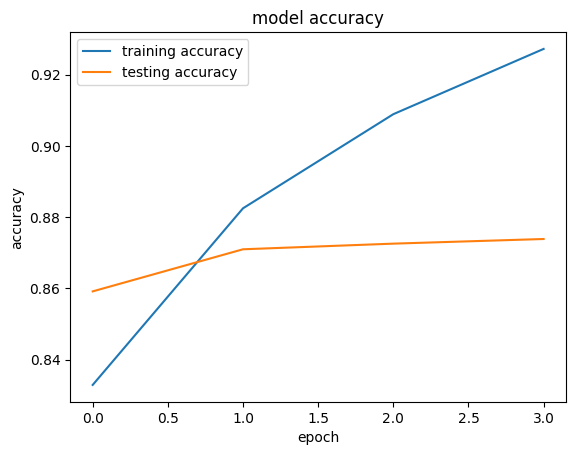

In [17]:
plt.plot(history.history["accuracy"],label="training accuracy")
plt.plot(history.history["val_accuracy"],label="testing accuracy")
plt.title("model accuracy")
plt.xlabel("epoch")
plt.ylabel("accuracy")
plt.legend()
plt.show()

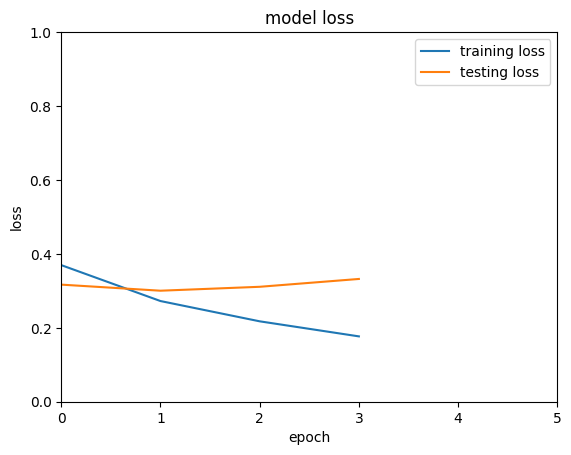

In [27]:
plt.plot(history.history["loss"],label="training loss")
plt.plot(history.history["val_loss"],label="testing loss")
plt.title("model loss")
plt.xlabel("epoch")
plt.ylabel("loss")
plt.ylim((0,1))
plt.xlim((0,5))
plt.legend()
plt.show()

## Model Evaluation

In [23]:
y_pred = model.predict(x_test)
y_pred.shape

4539/4539 ━━━━━━━━━━━━━━━━━━━━ 36s 8ms/step


(145224, 1)

In [24]:
y_pred = y_pred.squeeze()

In [25]:
y_pred_binary = np.where(y_pred>0.5,1,0)
y_pred_binary

array([0, 1, 1, ..., 1, 0, 1])

In [26]:
loss,accuracy = model.evaluate(x_test, y_test)
print("model loss",loss)
print("model accuracy",accuracy)

4539/4539 ━━━━━━━━━━━━━━━━━━━━ 39s 9ms/step - accuracy: 0.8712 - loss: 0.3002
model loss 0.3003596067428589
model accuracy 0.8709786534309387


In [28]:
from sklearn.metrics import accuracy_score,confusion_matrix
print(f"the accuracy score is:{accuracy_score(y_pred_binary,y_test)}")

the accuracy score is:0.8709786261224041


## Confusion Matrix

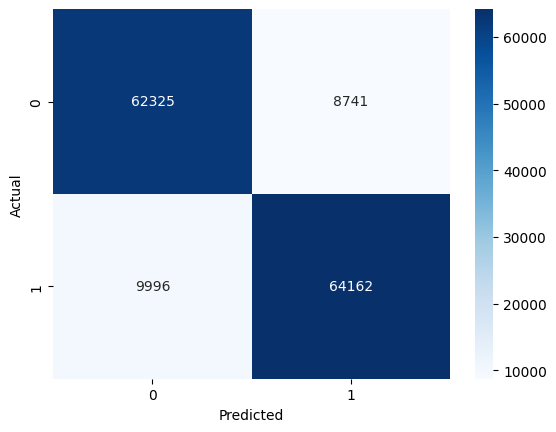

In [29]:
import seaborn as sns
con= confusion_matrix(y_pred_binary,y_test)
sns.heatmap(con,annot=True,fmt='d',cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

## Classification Report

In [30]:
from sklearn.metrics import classification_report

print(classification_report(y_test, y_pred_binary))

              precision    recall  f1-score   support

           0       0.88      0.86      0.87     72321
           1       0.87      0.88      0.87     72903

    accuracy                           0.87    145224
   macro avg       0.87      0.87      0.87    145224
weighted avg       0.87      0.87      0.87    145224



Breakdown:
F1-score 0.87 → strong balance between precision & recall

Class 0 & 1 are equally well-handled → no bias

Macro avg = Weighted avg = 0.87 → indicates class balance

Accuracy = 87% on ~145k samples → robust generalization

This has clearly been our best result and we hope to find improvisations with ensemble techniques such as bagging and parallelization of the same.

In [31]:
import pickle

# save the iris classification model as a pickle file
model_pkl_file = "bi_gru_model.pkl"  

with open(model_pkl_file, 'wb') as file:  
    pickle.dump(model, file)

In [ ]:
with open('tokenizer.pkl', 'wb') as f:
    pickle.dump(tokenizer, f)

In [ ]:
%cd /kaggle/working

In [32]:
from IPython.display import FileLink 
FileLink(r'tokenizer.pkl')
FileLink(r'biGRU_model.pkl')

/kaggle/working/bi_lstm_model.pkl